# Enrichment plot

In [2]:
import polars as pl
import polars.selectors as cs
import scipy.stats as stats

In [11]:
# Load datasets
# pValue = -1 when no p-value was assigned
CTCF = "../../../data/HepG2_CTCF_ENCSR000BIE/ENCFF254DEQ.bed.gz"
					#separator="\t", 
					#has_header=False, 
					#new_columns=["chr", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"])
H3k27ac = "../../../data/HepG2_H3K27ac_ENCSR000AMO/ENCFF392KDI.bed.gz"
					  #separator="\t", 
					  #has_header=False, 
					  #new_columns=["chr", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"])	
H3k4me3 = "../../../data/HepG2_H3K4me3_ENCSR575RRX/ENCFF982DUT.bed.gz"
					  #separator="\t", 
					  #has_header=False, 
					  #new_columns=["chr", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"])
ATAC = "../../../data/HepG2_ATAC_ENCSR042AWH/ENCFF913MQB.bed.gz"
					#separator="\t", 
					#has_header=False, 
					#new_columns=["chr", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"])	
RAD21 = "../../../data/HepG2_RAD21_ENCSR000EEG/ENCFF145VFI.bed.gz"
					#separator="\t", 
					#has_header=False, 
					#new_columns=["chr", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"])
cHiC = pl.read_csv("../../HiC_comparisons/CMPRA5_sorted.ibed",
				   	separator="\t")
promoters = "../figure2/promoters.bed.gz"
non_promoters = "../figure2/non_promoters.bed.gz"

## Bedtools intersect

In [12]:
# get q-values and overlapping bins. Note: bins are not unique.
!bedtools intersect -b $CTCF -a  $promoters -wa -wb | cut -f -3 |  sort -k1,1 -k2,2n | uniq  > temp.CTCF_proms.bed
!bedtools intersect -b $H3k27ac -a  $promoters -wa -wb | cut -f -3 |  sort -k1,1 -k2,2n | uniq  > temp.H3k27ac_proms.bed
!bedtools intersect -b $H3k4me3 -a  $promoters -wa -wb | cut -f -3 |  sort -k1,1 -k2,2n | uniq  > temp.H3k4me3_proms.bed
!bedtools intersect -b $ATAC -a  $promoters -wa -wb | cut -f -3 |  sort -k1,1 -k2,2n | uniq  > temp.ATAC_proms.bed
!bedtools intersect -b $RAD21 -a  $promoters -wa -wb | cut -f -3 |  sort -k1,1 -k2,2n | uniq  > temp.RAD21_proms.bed

In [13]:
CTCF_data = pl.read_csv("temp.CTCF_proms.bed", separator="\t", has_header=False, new_columns=["chr", "start", "end", "CTCF"])
H3k27ac_data = pl.read_csv("temp.H3k27ac_proms.bed", separator="\t", has_header=False, new_columns=["chr", "start", "end", "H3k27ac"])
H3k4me3_data = pl.read_csv("temp.H3k4me3_proms.bed", separator="\t", has_header=False, new_columns=["chr", "start", "end", "H3k4me3"])
ATAC_data = pl.read_csv("temp.ATAC_proms.bed", separator="\t", has_header=False, new_columns=["chr", "start", "end", "ATAC"])
RAD21_data = pl.read_csv("temp.RAD21_proms.bed", separator="\t", has_header=False, new_columns=["chr", "start", "end", "RAD21"])

ShapeError: 4 column names provided for a DataFrame of width 3

In [ ]:
CTCF_data = CTCF_data.select("CTCF", bin=pl.concat_str(["chr",  "start", "end"], separator="-")).group_by("bin").mean()
H3k27ac_data = H3k27ac_data.select("H3k27ac", bin=pl.concat_str(["chr",  "start", "end"], separator="-")).group_by("bin").mean()
H3k4me3_data = H3k4me3_data.select("H3k4me3", bin=pl.concat_str(["chr",  "start", "end"], separator="-")).group_by("bin").mean()
ATAC_data = ATAC_data.select("ATAC", bin=pl.concat_str(["chr",  "start", "end"], separator="-")).group_by("bin").mean()
RAD21_data = RAD21_data.select("RAD21", bin=pl.concat_str(["chr",  "start", "end"], separator="-")).group_by("bin").mean()


In [176]:
all_joined = MPRA_data.join(CTCF_data, on="bin"
						   ).join(H3k27ac_data, on="bin"
							).join(H3k4me3_data, on="bin"
			  				).join(ATAC_data, on="bin"
							).join(RAD21_data, on="bin")

In [178]:
all_joined.height

674

In [180]:
all_joined.filter(pl.col("label") != "promoter").height

674

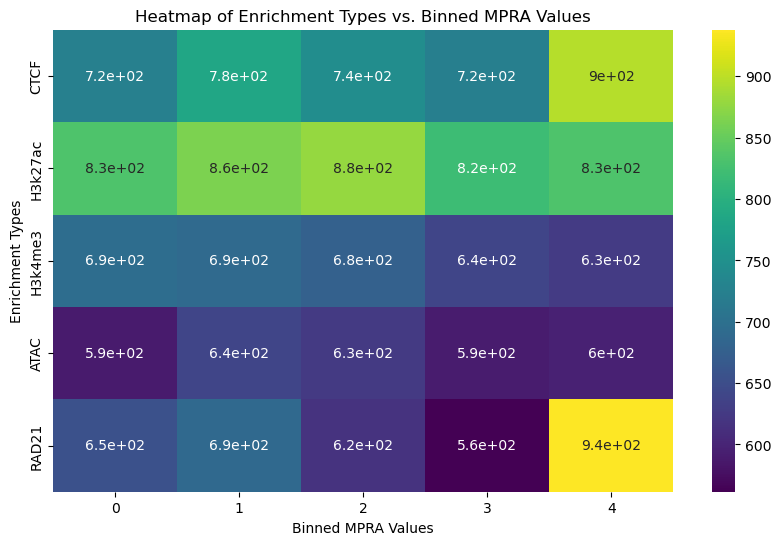

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Discretize MPRA values into bins
bins = [0, 0.5, 1.0, 1.5, 2.0]
labels = ['0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0']
logFC = pl.col("logFC")
to_plot = all_joined.with_columns(
	activity = pl.when(logFC < -1).then(pl.lit("0"))
	.when(logFC < 0).then(pl.lit("1"))
	.when(logFC < 1).then(pl.lit("2"))
	.when(logFC < 2).then(pl.lit("3"))
	.otherwise(pl.lit("4"))
	).group_by("activity").mean()

#to_plot = to_plot.pivot(columns="activity", values=["CTCF", "H3k27ac", "H3k4me3", "ATAC", "RAD21"],index="activity")
to_plot = to_plot.select(pl.exclude("bin", "label", "logFC")).sort("activity").transpose(include_header=True, header_name="Enrichment", column_names="activity")

# # Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(to_plot.to_pandas().set_index('Enrichment'), annot=True, cmap='viridis')
plt.title('Heatmap of Enrichment Types vs. Binned MPRA Values')
plt.xlabel('Binned MPRA Values')
plt.ylabel('Enrichment Types')
plt.show()